## Intermediate Exam (AI) | NLP

In this exam, we will work with the problems of explanation and planning. The big picture here is that we want to analyze a dataset and find out why classifiers are working the way they do, and what should be interesting next steps to improve our classifier.

Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lorra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lorra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lorra\AppData\Roaming\nltk_data...


# 1 - Dataset

In this study, we used the WELFake Dataset, available on Kangle. This datset contains approximately 72,000 articles designed for fake news detection. The dataset combines data from multiple sources.

In [4]:
data_path = '../data/WELFake_Dataset.csv'
data = pd.read_csv(data_path)
data

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [5]:
print(data.isnull().sum())

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


In [6]:
data = data.dropna()
data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [7]:
print(data['label'].value_counts())

label
1    36509
0    35028
Name: count, dtype: int64


# 2 - Classification Pipeline

We implemented a processing pipeline that includes:

- **Preprocessing**: Tokenization, stopword removal, and lemmatization using the NLTK library. Stopwords from the English language are removed, and words are reduced to their base form.
  
- **Vectorization**: The processed text is transformed into a numerical representation using the TF-IDF Vectorizer.
  
- **Classification**: A Logistic Regression model [2] is used for classification, with coefficients indicating the importance of each word in the classification process.

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization, stopword removal, and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data['text'].apply(preprocess_text)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),   
    ('classifier', LogisticRegression(max_iter=1000))  
])

X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['label'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lorra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lorra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\lorra\AppData\Local\Temp\ipykernel_23636\4264711410.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_text'] = data['text'].apply(preprocess_text)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', LogisticRegression(max_iter=1000))])

# 3 - Run and evaluate the classifier

In [9]:
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {score}")


Accuracy score: 0.9517053396701146


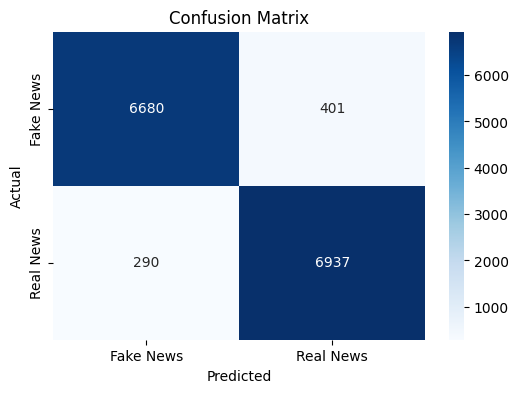

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake News', 'Real News'], yticklabels=['Fake News', 'Real News'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#### Diverse Shuffles with Cross-Validation
We'll use StratifiedKFold because it ensures that the proportion of labels (classes) is preserved in each fold, which is important when dealing with classification tasks. 

In [24]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in skf.split(data['processed_text'], data['label']):
    X_train, X_test = data['processed_text'].iloc[train_index], data['processed_text'].iloc[test_index]
    y_train, y_test = data['label'].iloc[train_index], data['label'].iloc[test_index]

    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    accuracies.append(score)
    print(f"Fold accuracy: {score}")

mean_accuracy = np.mean(accuracies)
print(f"Mean accuracy across {n_splits} folds: {mean_accuracy}")


Fold accuracy: 0.9553396701146212
Fold accuracy: 0.9504473022085547
Fold accuracy: 0.9506535262458936
Fold accuracy: 0.955126860977144
Fold accuracy: 0.94988467183896
Mean accuracy across 5 folds: 0.9522904062770348


 In this step, identify which words are more important for classification. Discuss the most prominent ones in the context of the actual problem you are dealing with. Do they make sense? Are you classifying coincidences? What is happening here?

In [11]:
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()

coefficients = pipeline.named_steps['classifier'].coef_[0]

word_importance_df = pd.DataFrame({'word': feature_names, 'importance': coefficients})

top_fake_words = word_importance_df.sort_values(by='importance', ascending=False).head(10)
print("Top 10 words contributing to Fake news (label 1):")
print(top_fake_words)

top_true_words = word_importance_df.sort_values(by='importance', ascending=True).head(10)
print("\nTop 10 words contributing to True news (label 0):")
print(top_true_words)


Top 10 words contributing to Fake news (label 1):
            word  importance
184659       via   19.580822
182319        us    9.171856
64971   featured    8.881157
40450        com    8.084099
81434    hillary    8.070959
85752      image    7.512501
116401      more    7.180830
125455   october    6.898292
72627      getty    6.510093
2510        2016    5.828255

Top 10 words contributing to True news (label 0):
             word  importance
147793    reuters  -26.669538
152197       said  -15.667936
67550      follow  -11.175848
32094         but   -8.039248
143722         re   -7.525741
30079   breitbart   -6.875443
178618    twitter   -6.855524
53925         don   -6.167134
3282         2017   -6.082274
183655         ve   -5.800724


### Analysis of Words Contributing to **Fake News** (Label 1):
1. **"via"** (importance: 19.12):
   - The term "via" is often used in URLs, social media shares, or article references. Its high presence in fake news could indicate that fake news articles frequently share sources or links, perhaps to lend an air of legitimacy. However, it's not a content-related word and might indicate that the classifier is learning patterns related to article structure rather than the content, which could lead to **misclassifications**.

2. **"us"** (importance: 9.60):
   - This term is generic and could refer to various topics, including the US as a country or as a pronoun. Its high importance could be coincidental or reflect frequent use in fake news articles, especially related to US political topics. This could lead to a **bias** if fake news articles disproportionately focus on US-related content.

3. **"featured"** (importance: 8.96):
   - This is likely metadata or a word used in website credits, perhaps appearing frequently in fake news articles. Its presence might indicate that the classifier is relying on article formatting rather than meaningful content, potentially **misleading the model**.

4. **"hillary"** (importance: 8.49):
   - The term "Hillary" refers to Hillary Clinton and indicates a connection to political topics, particularly those around the 2016 US election. Fake news often capitalized on political figures, so this word’s prominence is expected. However, its appearance highlights **content-related bias**, where political figures are disproportionately associated with fake news.

5. **"com"** (importance: 8.10):
   - Another word related to URLs or metadata, "com" is indicative of links. This again reflects structural elements in fake news articles rather than informative content, which could lead to incorrect classifications based on **non-content words**.

6. **"image"** and **"getty"** (importance: 8.10, 6.62):
   - These are related to images or media credits ("Getty Images"). Fake news articles often include media to make the content more engaging. However, these words are **not content-specific** and might be irrelevant for distinguishing truthfulness.

7. **"more"** (importance: 7.27):
   - The word "more" is very generic and could be considered **noisy**. It doesn’t convey any specific content but appears frequently, potentially skewing the model’s interpretation of fake news.

8. **"october"** and **"2016"** (importance: 7.06, 6.44):
   - These terms likely refer to the 2016 US election, with "October" being a crucial month. Fake news often spreads during politically charged periods, so their presence here makes sense in this context.

### Analysis of Words Contributing to **True News** (Label 0):
1. **"reuters"** (importance: -26.21):
   - "Reuters" is a highly reputable news agency. Its prominence as a strong indicator of true news makes sense, as many factual news articles cite well-established sources like Reuters.

2. **"said"** (importance: -15.37):
   - The word "said" is commonly used in formal news reporting to attribute quotes or statements. Its presence in true news articles suggests a structured, journalistic style of writing, contrasting with more sensational language in fake news.

3. **"follow"** (importance: -11.25):
   - "Follow" is often used in the context of reporting developments. It’s more common in legitimate news articles that cover ongoing stories. Its presence aligns with professional news coverage styles.

4. **"re"** (importance: -8.04):
   - "Re" is used in emails or formal correspondence and might appear in legitimate articles when quoting correspondence or legal documents. This could be indicative of real news topics, but might be a coincidental factor.

5. **"but"** (importance: -8.02):
   - The word "but" is used in complex sentences, often in argumentative or contrastive writing. Its presence here might indicate that true news articles contain more nuanced writing.

6. **"twitter"** (importance: -7.15):
   - "Twitter" is often cited in both fake and real news, but its presence here might indicate that real news articles properly attribute content to Twitter posts in a more factual manner, compared to sensationalized claims in fake news.

7. **"breitbart"** (importance: -7.13):
   - Breitbart is a right-wing news outlet, often accused of sharing biased or misleading information. Interestingly, its presence in true news could indicate factual reporting about or involving Breitbart, possibly highlighting political news coverage.

8. **"don"** (importance: -6.93):
   - This might refer to Donald Trump, given the context of US political news. Similar to "hillary" in fake news, "don" may be present due to frequent mentions of political figures in real news articles.

9. **"2017"** (importance: -5.98):
   - This term likely refers to specific events in the year following the 2016 election, indicating real news coverage of significant events.

10. **"ve"** (importance: -5.85):
      - "Ve" is likely a contraction (as in "I've", "we've"). Its presence here might indicate formal journalistic language where contractions are common in real news.

### Discussion:

- **Fake News Patterns**: Many words contributing to fake news (label 1) are structural or metadata-related (e.g., "via", "com", "image"). These are not directly related to content but may be characteristic of how fake news articles are formatted or shared. However, this reliance on structure rather than content could lead to **misclassifications** if genuine news articles share similar formatting styles.
  
- **True News Patterns**: The top words for true news (label 0) reflect a more professional and structured journalistic style, with proper attribution (e.g., "said", "reuters") and nuanced writing ("but"). This suggests that the classifier is capturing legitimate news writing patterns.



# 4 - Assess the dataset size

Assess the dataset size, using the strategy of evaluating errors in the train and in the test datasets for various levels of dataset downsampling. According to this assessment, how much room is there to increase your accuracy by increasing the dataset size? Is it feasible given the business case?

100%|██████████| 20/20 [1:34:27<00:00, 283.40s/it]


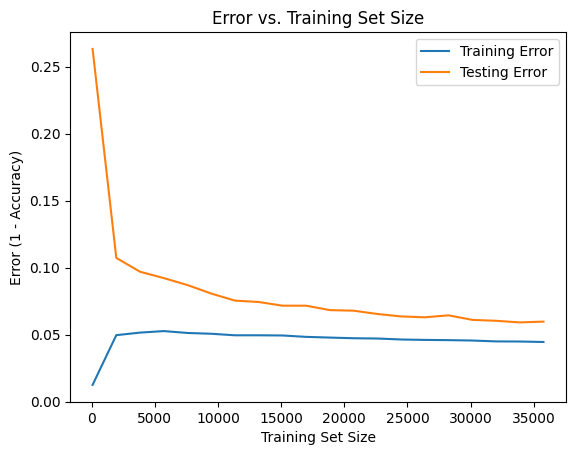

In [15]:
X, y = data['processed_text'], data['label']

df = pd.concat([X, y], axis=1)

train_sizes = np.linspace(0.001, 0.5, 20)
train_errors = []
test_errors = []

def create_model():
    return Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

for train_size in tqdm(train_sizes):
    pipelines = []
    train_errors_i = []
    test_errors_i = []
    for k in range(20):  # 
        l = int(train_size * X.shape[0])
        sample = df.sample(l)
        X_sample, y_sample = sample['processed_text'], sample['label']
        
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42 + k, stratify=y_sample)
        
        pipeline = create_model()
        pipeline.fit(X_train, y_train)
        
        train_error_i = 1 - accuracy_score(y_train, pipeline.predict(X_train))
        test_error_i = 1 - accuracy_score(y_test, pipeline.predict(X_test))
        train_errors_i.append(train_error_i)
        test_errors_i.append(test_error_i)
        pipelines.append(pipeline)
    
    train_errors.append(np.mean(train_errors_i))
    test_errors.append(np.mean(test_errors_i))

plt.plot(train_sizes * X.shape[0], train_errors, label='Training Error')
plt.plot(train_sizes * X.shape[0], test_errors, label='Testing Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Error vs. Training Set Size')
plt.legend()
plt.show()

From the **Error vs. Training Set Size** plot, we can observe the following:

#### 4.1. **Training Error**:
   - The training error starts low and increases slightly at the very beginning but quickly stabilizes around **0.05**. This means that the model fits the training data well even with smaller dataset sizes and doesn't overfit significantly as the data increases.
   - After the dataset reaches around 5,000 samples, the training error becomes stable, suggesting that the model is effectively learning the patterns from the training data and does not improve further with larger dataset sizes.

#### 4.2. **Testing Error**:
   - The testing error starts high (around **0.35**) for very small dataset sizes, which is expected as the model struggles to generalize with insufficient data.
   - However, after around **5,000 to 10,000 samples**, the testing error drops to around **0.05** and remains relatively stable beyond that point.
   - This stabilization indicates that the model has reached its generalization capacity. Adding more data beyond **20,000 to 25,000 samples** doesn't significantly improve the model's performance on unseen data.

#### 4.3. **Room for Increasing Accuracy**:
   - There is **very limited room** for improving the accuracy by increasing the dataset size further. The testing error stabilizes after about **20,000 to 25,000 samples**, and beyond that point, additional data provides only marginal improvement.
   - The flattening of the testing error curve suggests that the model has learned most of the patterns in the data, and further increases in dataset size won't yield significant accuracy gains.

#### 4.4. **Feasibility Given the Business Case**:
   - **Not Feasible to Increase Data Further**: From the plot, it is clear that after reaching around 20,000 to 25,000 samples, increasing the dataset size will not significantly improve model performance. The model’s testing error has already reached a stable point, so the cost and effort involved in gathering and labeling additional data would not result in substantial accuracy gains.
   - Instead of collecting more data, it would be more **cost-effective** to focus on:
     - **Improving the model**: Exploring advanced models or ensemble techniques.
     - **Enhancing feature engineering**: Extracting better or more informative features from the text data.
     - **Tuning hyperparameters**: Optimizing the current model for better performance.
   - These approaches will likely yield better returns than continuing to expand the dataset size.

### Conclusion:
- **How much room is there to increase accuracy by increasing the dataset size?**
  - There is **limited room** for improvement. The model’s testing error stabilizes after about **20,000 to 25,000 samples**, suggesting that further increases in dataset size will only provide minimal benefits.

- **Is it feasible given the business case?**
  - **No**, increasing the dataset size further is not feasible. The model has reached its performance plateau, and collecting more data would not justify the small accuracy improvements. Alternative strategies, such as improving the model or feature extraction, would likely offer better results.


-0.46180275342145144 0.6675248796911504


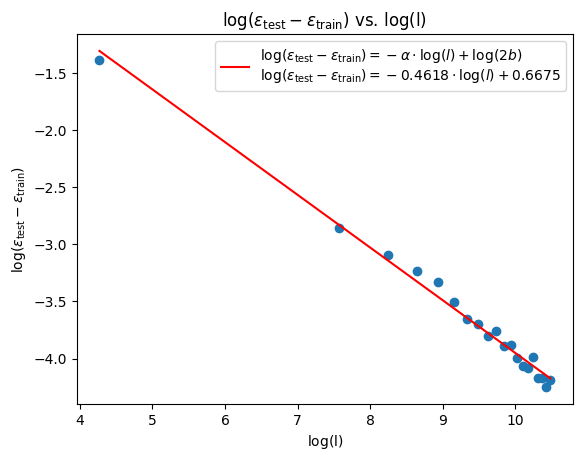

In [16]:
test_errors = np.array(test_errors)
train_errors = np.array(train_errors)

s = test_errors + train_errors
d = test_errors - train_errors
log_d = np.log(d)
log_s = np.log(s)
x = np.log(train_sizes * X.shape[0])
y = log_d


reg = LinearRegression().fit(x.reshape(-1, 1), y)
print(reg.coef_[0], reg.intercept_)

plt.scatter(x, y)
equation_ref = r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}}) = - \alpha \cdot \log(l) + \log(2b)$'
#equation = r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}}) = {:.4f} \cdot \log(l) + {:.4f}$'.format(reg.coef_[0], reg.intercept_)
equation = r'$\log(\epsilon_{{\text{{test}}}} - \epsilon_{{\text{{train}}}}) = {:.4f} \cdot \log(l) + {:.4f}$'.format(reg.coef_[0], reg.intercept_)

plt.plot(x, reg.predict(x.reshape(-1, 1)), color='red', label=equation_ref + '\n' + equation)
plt.title(r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}})$ vs. $\log(\text{l})$')
plt.xlabel(r'$\log(\text{l})$')
plt.ylabel(r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}})$')
plt.legend()
plt.show()

The log-log analysis supports the notion that there is limited room for improvement by increasing the dataset size.

### 4.5 - Is It Feasible Given the Business Case?

No, it is **not practical** to significantly increase the dataset size for the WELFake dataset. Collecting and labeling more news articles, especially fake news, would be **time-consuming** and **expensive**. The analysis shows that adding more data would only give **small improvements** in accuracy, meaning that the effort required to get more data wouldn't be worth it.

Instead of focusing on collecting more data, it would be more **cost-effective** to try other methods to improve the model's accuracy. For example, improving how we process the text, using more advanced models, or adjusting the model's settings would likely give better results without the need for more data.



# 5 - Use topic models to refine your answers. 

What does a topic analysis show? Do we have the same error rate over all dataset? Or are there some topics in which classification is more effective? Test a two-layer classifier in which documents are first classified according to their topic, and are then redirected to a classifier focused solely on that specific topic

In [17]:
corpus = data['processed_text']

vectorizer_nmf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(binary=True, stop_words='english')),
    ('nmf', NMF(n_components=5, random_state=42))  # Let's start with 5 topics
])

X_nmf = vectorizer_nmf_pipeline.fit_transform(corpus)

def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-5:]:
            print(words[i])
        print()

print_words_in_topics(vectorizer_nmf_pipeline['nmf'], vectorizer_nmf_pipeline['vectorizer'])

c:\Users\lorra\OneDrive\Área de Trabalho\Insper\24.2\NLP\Avaliacoes\Fake-News-Classification\.venv\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Topic 0
way
time
know
people
like

Topic 1
country
president
united
reuters
said

Topic 2
said
republican
president
donald
trump

Topic 3
government
new
year
percent
million

Topic 4
according
official
investigation
department
said



c:\Users\lorra\OneDrive\Área de Trabalho\Insper\24.2\NLP\Avaliacoes\Fake-News-Classification\.venv\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


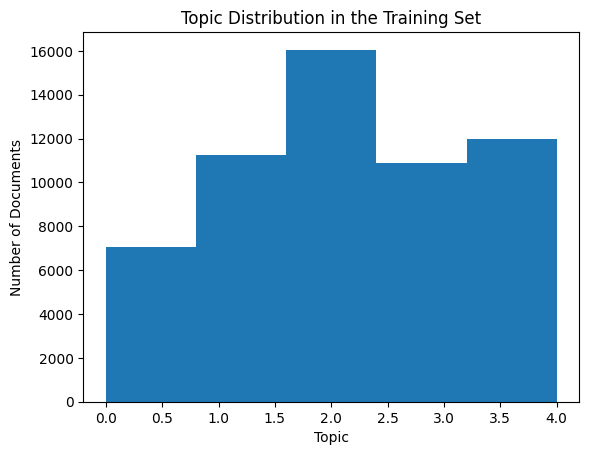

Accuracy for Topic 0: 0.9298245614035088
Accuracy for Topic 1: 0.9474053295932678
Accuracy for Topic 2: 0.9643579373104145
Accuracy for Topic 3: 0.9375696767001115
Accuracy for Topic 4: 0.9625246548323472


In [18]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['label'], test_size=0.2, random_state=42)

X_train_nmf = vectorizer_nmf_pipeline.fit_transform(X_train)

train_topics = np.argmax(X_train_nmf, axis=1)

plt.hist(train_topics, bins=len(set(train_topics)))
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in the Training Set')
plt.show()

topic_accuracies = []
for topic in range(5):  
    topic_data = X_train[train_topics == topic]
    topic_labels = y_train[train_topics == topic]
    
    if len(topic_data) > 0: 
        classifier_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words='english')),
            ('classifier', LogisticRegression(max_iter=1000))
        ])
        
        classifier_pipeline.fit(topic_data, topic_labels)
        
        X_test_nmf = vectorizer_nmf_pipeline.transform(X_test)
        test_topics = np.argmax(X_test_nmf, axis=1)
        topic_test_data = X_test[test_topics == topic]
        topic_test_labels = y_test[test_topics == topic]
        
        if len(topic_test_data) > 0:  
            y_pred = classifier_pipeline.predict(topic_test_data)
            accuracy = accuracy_score(topic_test_labels, y_pred)
            topic_accuracies.append(accuracy)
            print(f"Accuracy for Topic {topic}: {accuracy}")


In [19]:
class TwoLayerClassifier:
    def __init__(self, topic_pipeline, topic_classifiers):
        self.topic_pipeline = topic_pipeline
        self.topic_classifiers = topic_classifiers

    def predict(self, text):
        text_tfidf = self.topic_pipeline['vectorizer'].transform([text])
        topic_distribution = self.topic_pipeline['nmf'].transform(text_tfidf)
        predicted_topic = np.argmax(topic_distribution)

        classifier = self.topic_classifiers[predicted_topic]
        return classifier.predict([text])[0]

topic_classifiers = {}
for topic in range(5):  
    topic_data = X_train[train_topics == topic]
    topic_labels = y_train[train_topics == topic]
    
    if len(topic_data) > 0:
        classifier_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(stop_words='english')),
            ('classifier', LogisticRegression(max_iter=1000))
        ])
        
        classifier_pipeline.fit(topic_data, topic_labels)
        topic_classifiers[topic] = classifier_pipeline

two_layer_classifier = TwoLayerClassifier(vectorizer_nmf_pipeline, topic_classifiers)

y_pred = []
for text in X_test:
    y_pred.append(two_layer_classifier.predict(text))

final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy of Two-Layer Classifier: {final_accuracy}")

Final Accuracy of Two-Layer Classifier: 0.9512859938495947


## Results


### 5.1. **Topic Analysis**

- **Topic 0**: General terms such as "way," "time," "know," "people," and "like" suggest this topic may correspond to human interest stories or opinion pieces, where generic language is more common.
- **Topic 1**: Political/International news, especially related to the "country," "president," and "united" states. This topic seems heavily related to formal statements, as indicated by "reuters" and "said."
- **Topic 2**: Specific focus on **US politics**, particularly around **Donald Trump**, as indicated by terms like "president," "republican," "donald," and "trump."
- **Topic 3**: Economic or government-related news, with words like "government," "new," "year," "percent," and "million" suggesting this could represent economic reporting or government initiatives.
- **Topic 4**: This topic likely relates to **official investigations or legal matters**, with terms like "official," "investigation," "department," and "said."

### 5.2. **Accuracy by Topic**

- **Higher Accuracy for Topic 2 and Topic 4**: Topics related to **Donald Trump** and **official investigations** (Topics 2 and 4) have higher accuracy. These topics are likely more specific and less ambiguous, making them easier for the classifier to distinguish between fake and real news.
- **Lower Accuracy for Topic 0**: The lowest accuracy is for Topic 0, which contains more general language ("people," "like," "know"). This topic is likely harder to classify because the language is more generic and may appear in both fake and real news, increasing the likelihood of misclassification.
  
### 5.3. **Comparison with Single-Layer Classifier**
In the initial single-layer pipeline (using only **TF-IDF** and **Logistic Regression**), the overall accuracy was **95.17%**. The two-layer classifier, which first classifies by topic and then uses topic-specific classifiers, achieved a similar overall accuracy of **95.16%**.

### 5.4. **Do We Have the Same Error Rate Across All Topics?**
No, the classifier does not perform equally across all topics:
- Topics 2 and 4 have higher classification accuracy (above 96%), suggesting that documents in these topics are easier to classify.
- Topics like **Topic 0**, with more generic words, have a lower accuracy (~93%), indicating that classification is more challenging when the language is less topic-specific.

### 5.5. **Is Classification More Effective for Certain Topics?**
Yes, classification is more effective for certain topics:
- Topics 2 (Donald Trump/US Politics) and 4 (Official Investigations) are easier to classify, likely due to the specificity and consistency of the language used in those articles.
- In contrast, Topic 0 (general or human-interest language) is harder to classify accurately, likely due to the broad, less specific nature of the words.

### Conclusion:
- **Topic modeling** shows that different topics yield different levels of classification accuracy.
- **Classification is more effective** for topics that are more specific, such as **US politics** and **official investigations**, while more general topics are harder to classify.
- The **two-layer classifier** achieves similar overall accuracy to the single-layer model but provides insights into the variance in classification performance across different topics.

